# Train Stock Prive Prediction Model

This model predic the open price of the next day of the specific stock.

## Import Packages

In [1]:
import os
import yaml
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

## Constants & Settings

In [2]:
CONFIG_FILE = "/workspaces/valuation/config.yaml"

# Load config file
with open(CONFIG_FILE, 'r') as config_file:
    config = yaml.safe_load(config_file)

SEED = config['seed']
TICKER = config['ticker']
LOOK_FORWARD_DAYS = config['test_size_in_days'] # Number of days in the tail.
DATA_SOURCE_FOLDER = os.path.join("/workspaces/valuation/data/staging/stocks", TICKER)

## Read Preprocessed Data

In [3]:
train = pd.read_csv(os.path.join(DATA_SOURCE_FOLDER, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_SOURCE_FOLDER, 'test.csv'))

## Transform Data

In [4]:
train["ds"] = pd.to_datetime(train["ds"])
test["ds"] = pd.to_datetime(test["ds"])

train.drop(columns=["Open", "Adj Close", "Ticker", "Volume", "High", "Low", "Close"], inplace=True)
test.drop(columns=["Open", "Adj Close", "Ticker", "Volume", "High", "Low", "Close"], inplace=True)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

## Model Training

In [5]:
model = Prophet()
#model.add_country_holidays(country_name='Brazil')
#model.add_regressor('High', standardize=False)
#model.add_regressor('Low', standardize=False)
#model.add_regressor('Close', standardize=False)
model.fit(train)

21:05:26 - cmdstanpy - INFO - Chain [1] start processing
21:05:26 - cmdstanpy - INFO - Chain [1] done processing


## Predict

In [6]:
# future = model.make_future_dataframe(periods=LOOK_FORWARD_DAYS)

# Create a date range for the next N business days
future_dates = pd.date_range(start=train['ds'].max() + pd.Timedelta(days=1), 
                             periods=LOOK_FORWARD_DAYS, 
                             freq='B')  # 'B' for business days, skipping weekends

# Create a DataFrame with these future dates
future = pd.DataFrame({'ds': future_dates})

# Make predictions
forecast = model.predict(future)

# Merge the prediction with test data
predict = forecast.merge(test.reset_index(drop=True), how='inner', on='ds')

# Merge forecast with test data
forecast = forecast.merge(test.reset_index(drop=True), how='left', on='ds')

## Plot

/home/devuser/.local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/devuser/.local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


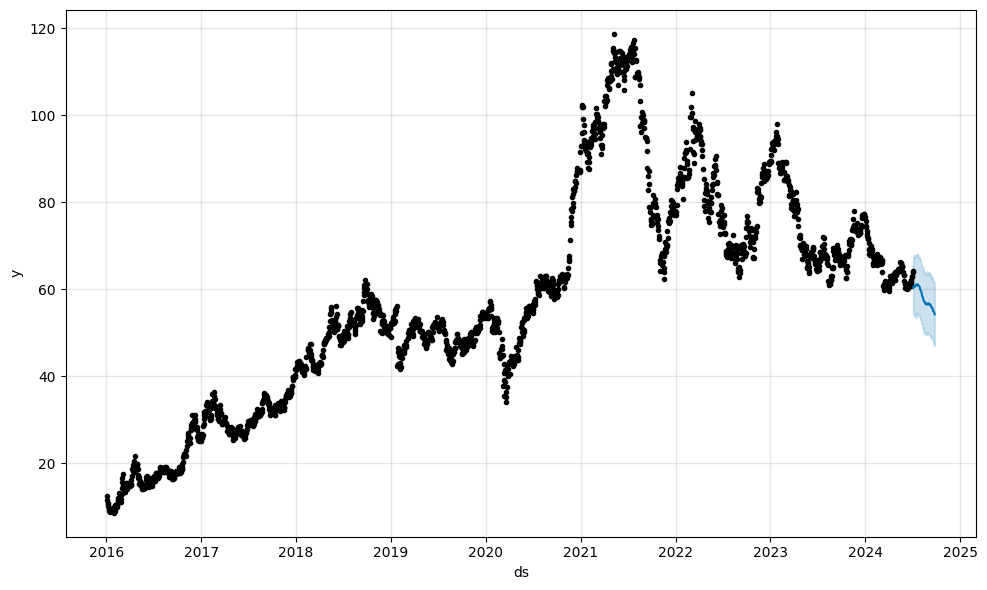

In [7]:
fig1 = model.plot(forecast)


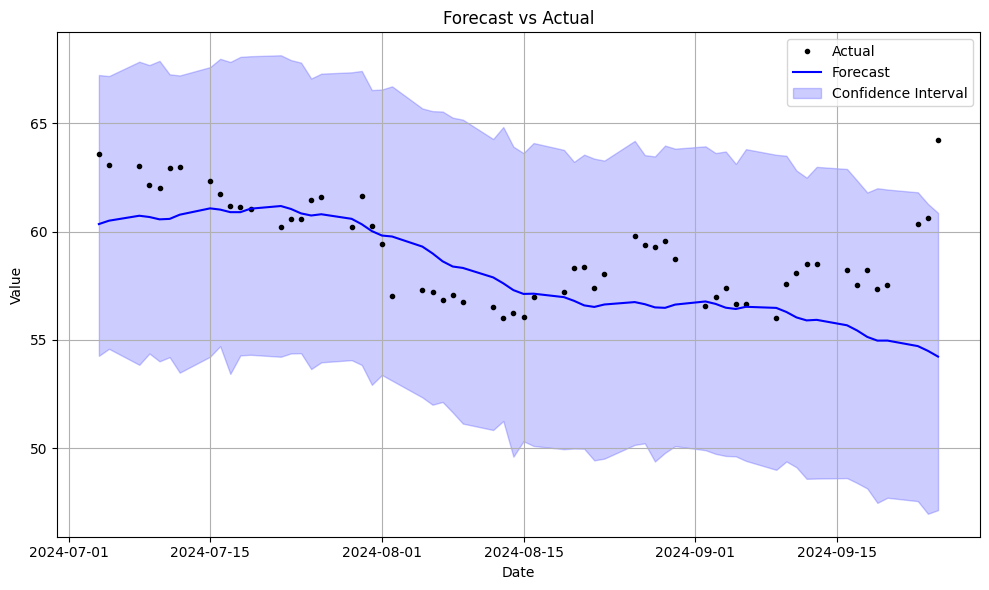

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(predict['ds'], predict['y'], 'k.', label='Actual')
plt.plot(predict['ds'], predict['yhat'], 'b-', label='Forecast')
plt.fill_between(predict['ds'], predict['yhat_lower'], predict['yhat_upper'], color='b', alpha=0.2, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/home/devuser/.local/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/devuser/.local/lib/python3.9/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/devuser/.local/lib/python3.9/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old 

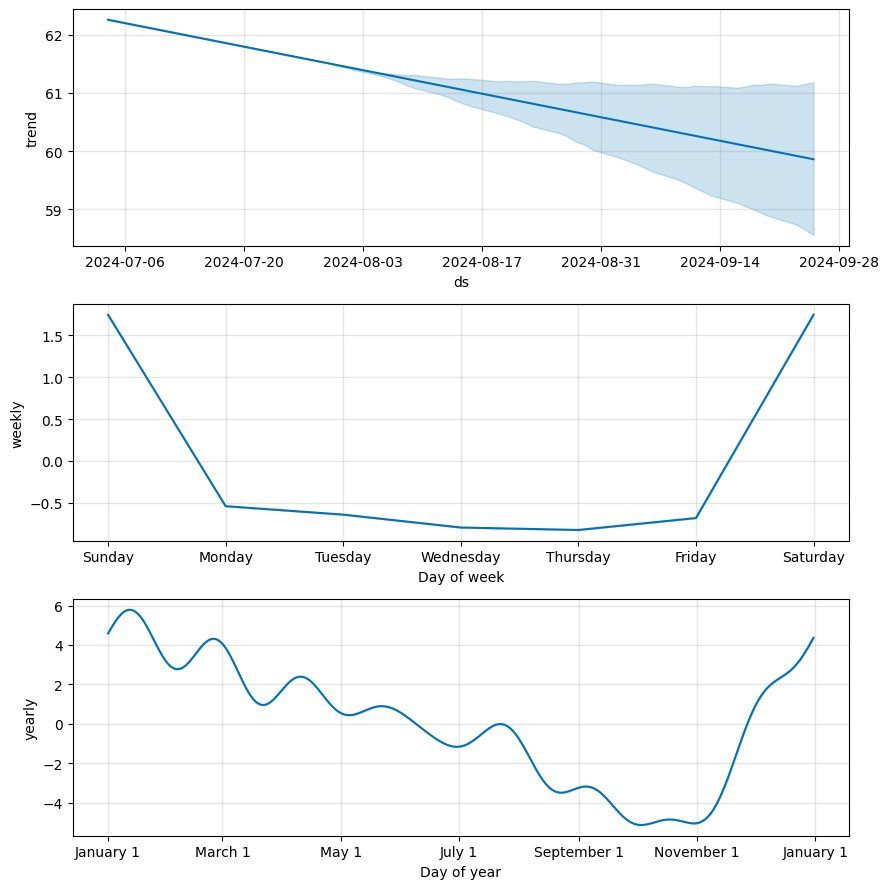

In [9]:
fig2 = model.plot_components(forecast)

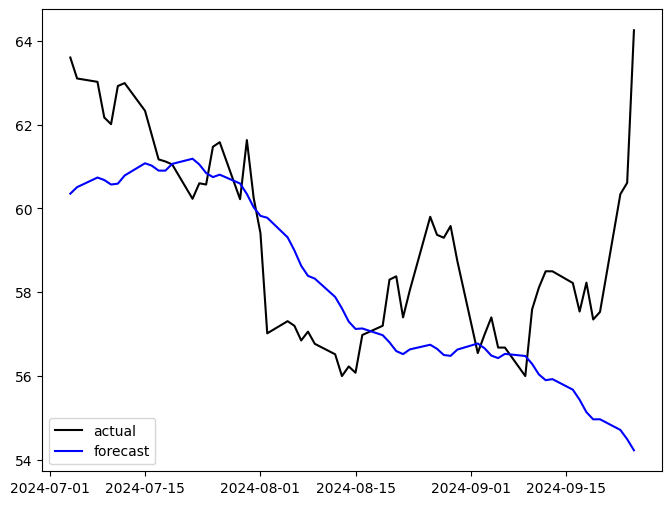

In [10]:
plt.figure(figsize=(8,6))
plt.plot(predict['ds'],predict['y'],color='black',label='actual')
plt.plot(predict['ds'],predict['yhat'],color='blue',label='forecast')
plt.legend()

## Calculate the Mean Squared Error

In [11]:
root_mean_squared_error(predict["yhat"], predict["y"])

2.3879455417691657